# Set up

Python librairies imports :

In [1]:
# File system management
import os
from pathlib import Path
import io

# Data manipulation
import numpy as np
import pandas as pd
from typing import Iterator

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image manipulation
from PIL import Image

# Dimension reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Tensorflow
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# Pyspark
from pyspark.ml.feature import PCA as pyPCA
from pyspark.ml.functions import array_to_vector, vector_to_array
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

%matplotlib inline
sns.set_theme(palette="Set2")

Define work location :

In [2]:
# Current project path
PATH_PROJ = "/Users/victor/Documents/OPENCLASSROOMS/projet_8"

# Define images paths
PATH_DATA = PATH_PROJ + "/data/test"
PATH_RESULTS = PATH_PROJ + "/data/results"

# Change directory
os.chdir(PATH_PROJ)

# Data exploration

In [3]:
# Count images
img_count = len([f for f in Path(PATH_DATA).rglob('*.jpg') if f.is_file()])
print("Number of JPG files in " + PATH_DATA + " : " + str(img_count))

Number of JPG files in /Users/victor/Documents/OPENCLASSROOMS/projet_8/data/test : 22688


In [4]:
# Create list of images
images_list = [(file_name, dir_path.split('/')[-1]) for (dir_path, _, file_names) in os.walk(PATH_DATA) \
               for file_name in file_names if file_name.endswith('.jpg')]

# Create dataframe
images_df = pd.DataFrame(images_list, columns=['image', 'label'])

# Add categories
images_df['category'] = images_df['label'].apply(lambda x: x.split(' ')[0])
display(images_df.head())

,image,label,category
0,r_226_100.jpg,Tomato 4,Tomato
1,121_100.jpg,Tomato 4,Tomato
2,188_100.jpg,Tomato 4,Tomato
3,153_100.jpg,Tomato 4,Tomato
4,r_219_100.jpg,Tomato 4,Tomato


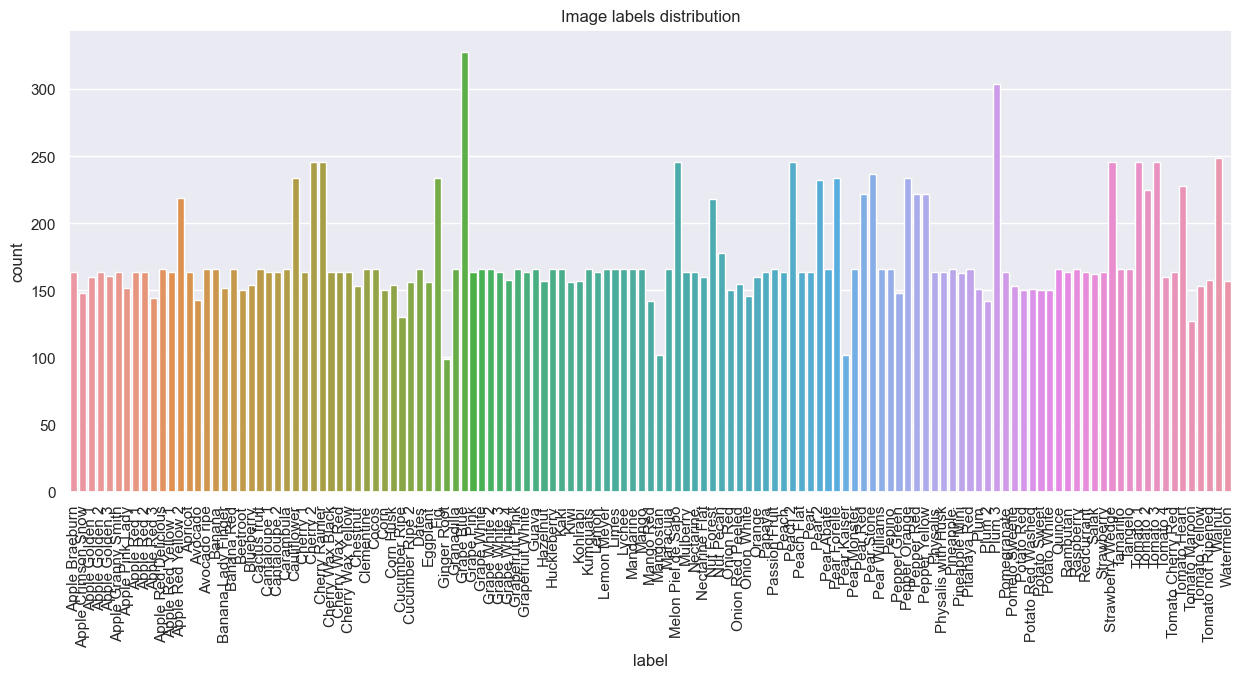

Number of labels : 131


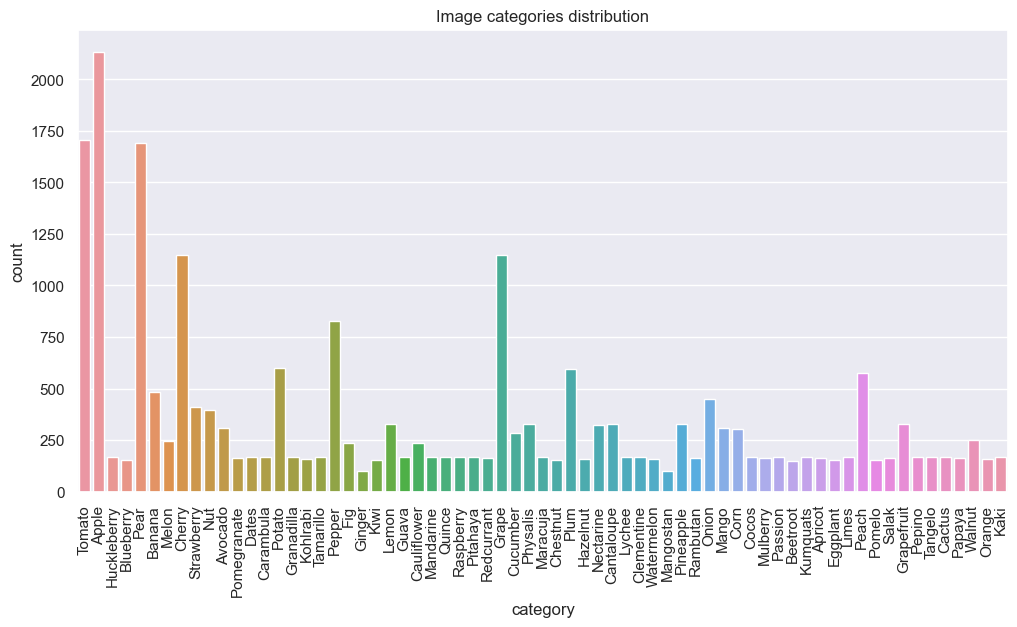

Number of categories : 67


In [5]:
# Display image labels
plt.figure(figsize=(15, 6))
plt.title("Image labels distribution")
sns.countplot(x=images_df['label'].sort_values())
plt.xticks(rotation=90)
plt.show()

print("Number of labels :", str(images_df['label'].nunique()))

# Display image categories
plt.figure(figsize=(12, 6))
plt.title("Image categories distribution")
sns.countplot(x=images_df['category'])
plt.xticks(rotation=90)
plt.show()

print("Number of categories :", str(images_df['category'].nunique()))

# Data processing

## Functions

### MobileNetV2 model

In [6]:
def model_create(show_summary=False):
    """Create a MobileNetV2 model with top layer removed

    Returns:
        MobileNetV2 model
    """
    # Load default model
    model_base = MobileNetV2(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

    # Freeze layers
    for layer in model_base.layers:
        layer.trainable = False

    # Create model without top layer
    model_new = Model(inputs=model_base.input, outputs=model_base.layers[-2].output)

    # Show model summary
    if show_summary is True:
        print(model_new.summary())

    return model_new

### Images preprocesssing

In [7]:
def preprocess(content):
    """Preprocesses raw image bytes.

    Args:
        content: PIL Image

    Returns:
        Numpy array
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

In [8]:
def featurize_series(model, content_series):
    """Featurize a pd.Series of raw images using the input model.

    Args:
        model: CNN model
        content_series: pd.Series of image data

    Returns:
        pd.Series of image features
    """
    content_input = np.stack(content_series.map(preprocess))
    preds = model.predict(content_input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

## Distributed model inference

### Create the Spark session

In [9]:
# Create sparkSession
spark = (SparkSession
         .builder
         .appName('oc_p8')
         .master('local')
         .config("spark.sql.parquet.writeLegacyFormat", 'true')
         .config("spark.driver.bindAddress", "127.0.0.1")
         .getOrCreate())

# Create sparkContext
sc = spark.sparkContext

# Set log level
sc.setLogLevel("WARN")

spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/23 11:19:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Broadcast the model weights

In [10]:
# Broadcast weights of mobile net v2 model
broadcast_weights = spark.sparkContext.broadcast(model_create(show_summary=True).get_weights())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [11]:
@F.pandas_udf("array<float>")
def featurize_udf(content_series_iter: Iterator[pd.Series]) -> Iterator[pd.Series]:
    """This method is a Scalar Iterator pandas UDF wrapping our featurization function.
        The decorator specifies this returns a Spark DataFrame column of type ArrayType(FloatType).

    Args:
        content_series_iter: Iterator over batches of data, where each batch
                            is a pandas Series of image data.

    Yields:
        pd.Series of image features
    """
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_create()
    # Broadcast weights to workers
    model.set_weights(broadcast_weights.value)
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

### Load the images

In [12]:
# Load all images
images = spark.read.format("binaryFile").option("pathGlobFilter", "*.jpg").option("recursiveFileLookup", "true").load(PATH_DATA)

In [16]:
# Display first images
images = images.withColumn('label', F.element_at(F.split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))
print("Number of images loaded : ", images.count())

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+---------------------------------------------------------------------------------------+----------+
|path                                                                                   |label     |
+---------------------------------------------------------------------------------------+----------+
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/test/Watermelon/r_106_100.jpg|Watermelon|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/test/Watermelon/r_109_100.jpg|Watermelon|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/test/Watermelon/r_108_100.jpg|Watermelon|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/test/Watermelon/r_107_100.jpg|Watermelon|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/test/Watermelon/r_95_100

Number of images loaded :  22688


### Run the model inference

In [17]:
# Select sample of dataset
SELECT_RATIO = 0.1
images = images.sample(fraction=SELECT_RATIO, seed=42)
print("Select {0:.0%} of images : {1}".format(SELECT_RATIO, images.count()))

Select 10% of images : 2264


In [18]:
# Create the image features
features_df = images.select(F.col("path"), F.col("label"),
                                                   featurize_udf("content").alias('features'))

# Create the vectors
features_df = features_df.withColumn('features_vec', array_to_vector("features"))

display(features_df.show(5))
display(features_df.printSchema())

2023-03-23 11:22:12.052063: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


+--------------------+----------+--------------------+--------------------+
|                path|     label|            features|        features_vec|
+--------------------+----------+--------------------+--------------------+
|file:/Users/victo...|Watermelon|[0.15326482, 0.44...|[0.15326482057571...|
|file:/Users/victo...|Watermelon|[0.60736394, 0.06...|[0.60736393928527...|
|file:/Users/victo...|Watermelon|[0.0023442288, 0....|[0.00234422879293...|
|file:/Users/victo...|Watermelon|[0.03623792, 0.15...|[0.03623792156577...|
|file:/Users/victo...|Watermelon|[1.2728374, 0.503...|[1.27283740043640...|
+--------------------+----------+--------------------+--------------------+
only showing top 5 rows



None

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_vec: vector (nullable = true)



None

In [19]:
# Save results as parquet files
features_df.write.mode("overwrite").parquet(PATH_RESULTS + "/Features_output")

# Dimension reduction

In [20]:
# Load results as a dataframe
res_df = pd.read_parquet(PATH_RESULTS, engine='pyarrow')

# Add categories
res_df['category'] = res_df['label'].apply(lambda x: x.split(' ')[0])

display(res_df.head())

,path,label,features,features_vec,category
0,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,Watermelon,"[0.15326482, 0.44225562, 0.0, 0.056562472, 0.9...","{'type': 1, 'size': None, 'indices': None, 'va...",Watermelon
1,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,Watermelon,"[0.60736394, 0.06201598, 0.0, 0.02030069, 0.00...","{'type': 1, 'size': None, 'indices': None, 'va...",Watermelon
2,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,Watermelon,"[0.0023442288, 0.6733391, 0.0, 0.010520196, 3....","{'type': 1, 'size': None, 'indices': None, 'va...",Watermelon
3,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,Watermelon,"[0.03623792, 0.1549782, 0.0, 0.04870774, 0.889...","{'type': 1, 'size': None, 'indices': None, 'va...",Watermelon
4,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,Watermelon,"[1.2728374, 0.5031278, 0.0, 0.029286705, 0.492...","{'type': 1, 'size': None, 'indices': None, 'va...",Watermelon


In [21]:
# Number features
features_n = res_df.loc[0, 'features'].shape[0]
print("The dimension of the features is", features_n)

The dimension of the features is 1280


### TSNE

,TSNE1,TSNE2,category
0,-7.834033,7.664864,Watermelon
1,-7.707822,8.619282,Watermelon
2,-11.103498,5.399245,Watermelon
3,-7.918263,7.556883,Watermelon
4,-8.308273,8.011163,Watermelon


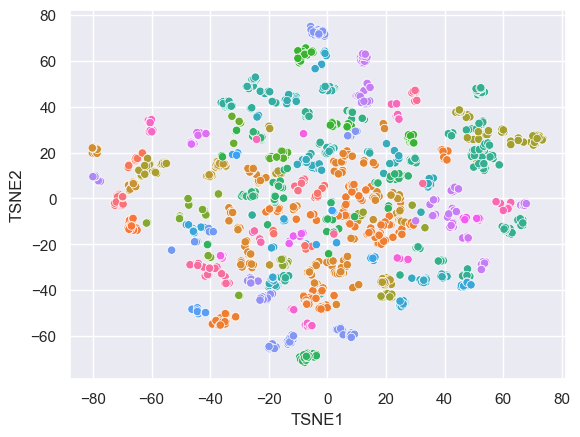

In [22]:
# Extract features
features = pd.DataFrame(res_df['features'].values.tolist(), index=res_df.index)

# Create t-sne dataframe
tsne_df = pd.DataFrame(TSNE(perplexity=20).fit_transform(features), columns=['TSNE1', 'TSNE2'])

# Add category
tsne_df['category'] = res_df['category']
display(tsne_df.head())

# Display scatterplot
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='category')
# plt.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.)
plt.legend([], [], frameon=False)
plt.show()

### Sklearn PCA

In [23]:
# Number of components
PCA_K = 200

In [24]:
# Create PCA model
pca = PCA(n_components=PCA_K)

# Fit to data 
pca_data = pca.fit_transform(features)
pca_df = pd.DataFrame(pca_data, columns=['PCA'+str(i) for i in range(1, pca_data.shape[1]+1)])
display(pca_df.head())


,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA191,PCA192,PCA193,PCA194,PCA195,PCA196,PCA197,PCA198,PCA199,PCA200
0,-5.849042,3.422906,1.949113,-0.109408,-4.788744,3.219925,-7.010310,-1.830579,5.281979,2.194451,...,0.100620,0.199608,0.513639,-0.138183,0.941159,-0.149451,-0.394977,-0.575281,-0.272975,0.048832
1,-6.687403,3.403110,0.307772,-0.821188,-2.159615,3.420472,-7.738785,-3.256703,4.570345,3.152647,...,0.844866,-0.794541,0.452114,1.141001,0.770270,0.003514,0.700096,-1.019524,-0.719126,0.399195
2,-2.833359,2.411277,1.271399,-0.477065,-1.084557,2.949566,-2.168059,-0.764272,0.500991,-2.682121,...,-0.436535,0.167826,0.001488,0.370556,-0.153313,0.034355,-0.958173,0.394888,1.075049,-0.413756
3,-6.017391,2.678030,0.602811,-1.399482,-4.907887,2.099690,-6.586209,-2.316017,4.323552,2.105900,...,0.056930,0.115981,0.268881,-0.037819,0.917326,-0.178004,-0.528973,-0.271927,-0.134969,-0.027121
4,-6.708078,2.767303,0.754876,0.302529,-2.819491,3.087967,-5.020428,-1.785982,5.991055,1.896878,...,0.230706,-0.137095,-0.309111,-0.341929,0.460868,-0.269316,-0.086997,-0.106341,-0.248450,0.462348


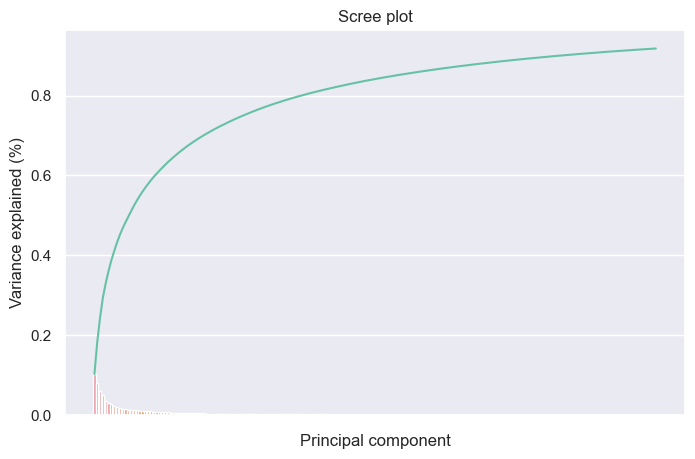

In [25]:
# Get explained variance ratio
pca_evr = list(pca.explained_variance_ratio_)
pca_evr_cumsum = np.cumsum(pca_evr)

# Display 
plt.figure(figsize=(8, 5))
plt.title("Scree plot")
sns.barplot(x=pca_df.columns, y=pca_evr)
sns.lineplot(x=pca_df.columns, y=pca_evr_cumsum)
plt.xlabel('Principal component')
plt.xticks('')
plt.ylabel('Variance explained (%)')
plt.show()

In [26]:
# Find thresholds
for th_val in [0.8, 0.85, 0.90, 0.95, 100]:
    th_idx = np.argmax(pca_evr_cumsum > th_val)
    if th_idx > 0:
        print('{:.0%} of the variance is explained by {} principal components ({:.4})' \
              .format(th_val, th_idx+1, pca_evr_cumsum[th_idx]))

# Show max component
print('{:.0%} of the variance is explained by {} principal components ({:.4})' \
              .format(pca_evr_cumsum[PCA_K-1], PCA_K, pca_evr_cumsum[PCA_K-1]))


80% of the variance is explained by 75 principal components (0.8014)
85% of the variance is explained by 108 principal components (0.8507)
90% of the variance is explained by 166 principal components (0.9)
92% of the variance is explained by 200 principal components (0.9178)


### Pyspark PCA

In [ ]:
# Create pyspark PCA model
pca = pyPCA(k=PCA_K, inputCol='features_vec', outputCol='features_pca')

# Fit model
pca_model = pca.fit(features_df)

# Transform data
features_df = pca_model.transform(features_df)

display(features_df.show(5))
display(features_df.printSchema())

In [ ]:
display(features_df.show(5))
display(features_df.printSchema())

In [ ]:
# Save PCA output as single json file
features_df.select(F.col('features_pca')).withColumn('features_pca', vector_to_array('features_pca')) \
    .repartition(1) \
    .write \
    .mode("overwrite") \
    .json(PATH_RESULTS + "/PCA_output")